In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [12]:
%ls ../wheather_data/

Pr_obfs.csv   v11_obfs.csv  v15_obfs.csv  v1_obfs.csv   v4_obfs.csv
kg_obfs.csv   v14_obfs.csv  v19_obfs.csv  v2_obfs.csv   v8_obfs.csv


In [13]:
%cd ../weather_data/
v1 = pd.read_csv('v1_obfs.csv')
v2 = pd.read_csv('v2_obfs.csv')
v4 = pd.read_csv('v4_obfs.csv')
v8 = pd.read_csv('v8_obfs.csv')

/Users/MD/time_series_clustering/weather_data


In [14]:
v = [v1, v2, v4, v8]
v_names = ['v1', 'v2', 'v4', 'v8', 'v11', 'v14', 'v15', 'v19']
sel_columns = [' Meas_5', ' Meas_6', ' Meas_7', ' Meas_8', ' Meas_9', ' Meas_10']
sel_column = [' Meas_5']

### Functions

In [28]:
def sliding_window(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    x, y = [], []
    line_size = data.shape[0]
    for start in range(0, line_size, step_size):
        stop = start + train_test_size
        if stop <= line_size:
            x.append(data[start: start+train_size])
            y.append(data[start+train_size: start+train_size+test_size])
    return np.array(x), np.array(y)


def norm_ts(data):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


def model_mae_2_naive(model, x_test, x_test_original, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae_2_naive = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae = np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
        naive = np.mean(np.abs(x_test_original[i, -1] - y_test[i, :]))
        mae_2_naive += mae / naive
    mae_2_naive /= n
    print ('current model / naive = {0:0.4f}'.format(mae_2_naive))
    return None


### Parameters of Sliding Window

In [18]:
train_size = 168
test_size = 24
train_test_size = train_size + test_size
# line_size = v1.shape[1]
step_size = 1
train_test_split = int(.75 * v1.shape[0])

### Normalization

In [19]:
data= v1[sel_column].values

train_xy = data[:train_test_split]

test_xy = data[train_test_split:]

train_xy_normed, scaler = norm_ts(train_xy)


train_x, train_y = sliding_window(data=train_xy_normed,
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)

test_x_original, test_y_original = sliding_window(data=np.squeeze(test_xy),
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)


test_x, scaler_test = norm_ts(test_x_original.T)
test_x = test_x.T

train_x, test_x = train_test_reshape(train_x, test_x)
print (train_x.shape, test_x.shape, test_y_original.shape)

(6373, 168, 1) (1998, 168, 1) (1998, 24)


### CNN network

In [20]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [21]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4461 samples, validate on 1912 samples
Epoch 1/20
 - 1s - loss: 0.0239 - mean_absolute_error: 0.1002 - val_loss: 0.0133 - val_mean_absolute_error: 0.0740
Epoch 2/20
 - 1s - loss: 0.0132 - mean_absolute_error: 0.0768 - val_loss: 0.0113 - val_mean_absolute_error: 0.0680
Epoch 3/20
 - 1s - loss: 0.0111 - mean_absolute_error: 0.0698 - val_loss: 0.0102 - val_mean_absolute_error: 0.0632
Epoch 4/20
 - 1s - loss: 0.0099 - mean_absolute_error: 0.0651 - val_loss: 0.0098 - val_mean_absolute_error: 0.0613
Epoch 5/20
 - 1s - loss: 0.0090 - mean_absolute_error: 0.0617 - val_loss: 0.0089 - val_mean_absolute_error: 0.0571
Epoch 6/20
 - 1s - loss: 0.0083 - mean_absolute_error: 0.0587 - val_loss: 0.0085 - val_mean_absolute_error: 0.0551
Epoch 7/20
 - 1s - loss: 0.0078 - mean_absolute_error: 0.0563 - val_loss: 0.0082 - val_mean_absolute_error: 0.0540
Epoch 8/20
 - 1s - loss: 0.

### Comparison to Naive model

In [29]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)
model_mae_2_naive(model,
                  x_test=test_x,
                  x_test_original=test_x_original,
                  y_test = test_y_original,
                  scaler=scaler_test,
                  inv_norm=True)

naive model = 1538.0077
current model = 707.7929
current model / naive = 0.5163


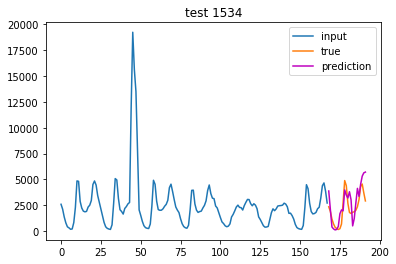

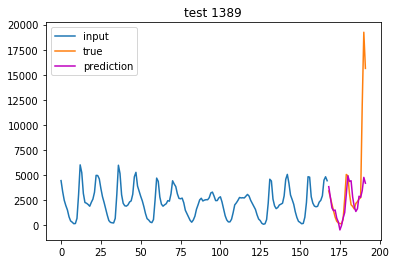

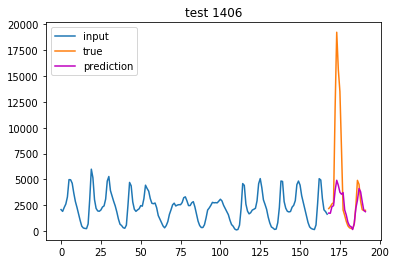

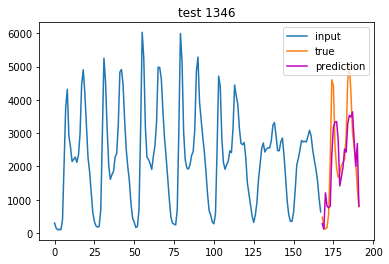

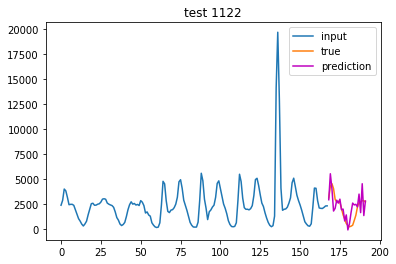

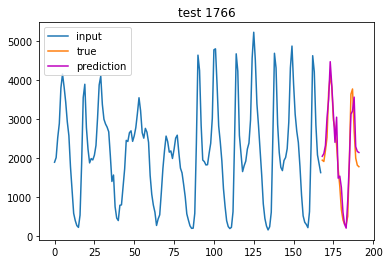

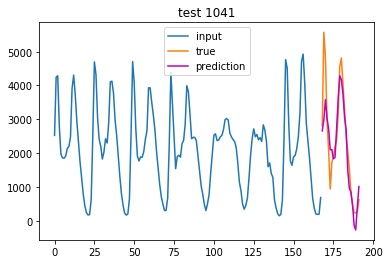

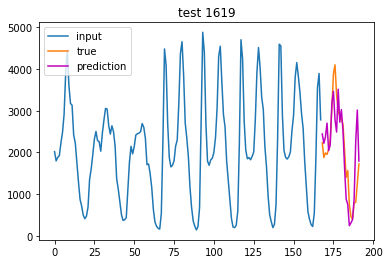

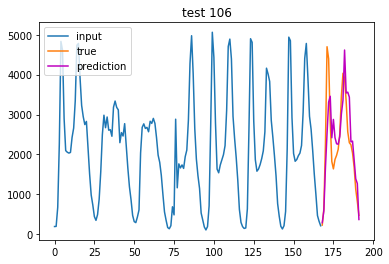

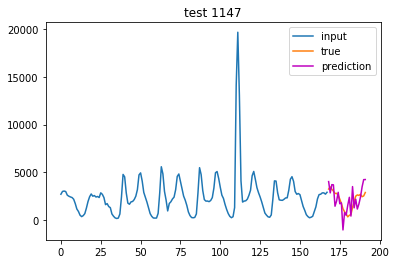

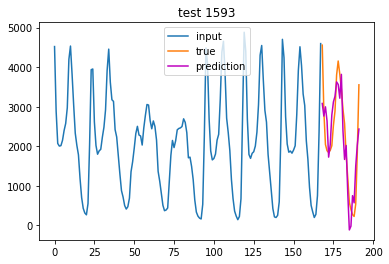

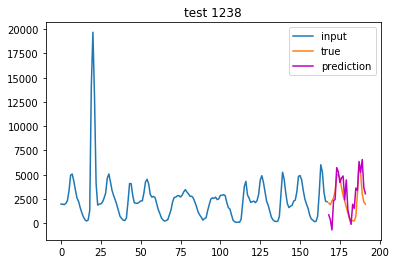

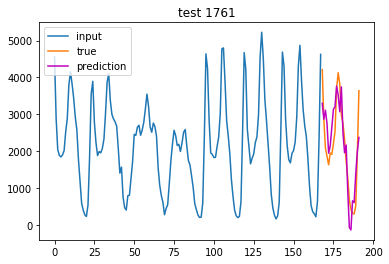

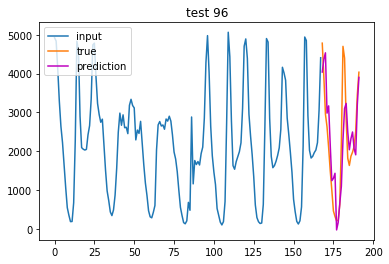

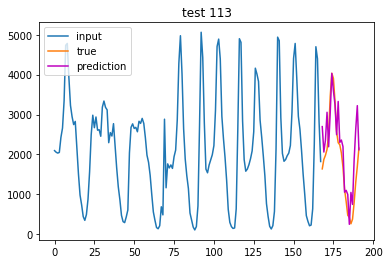

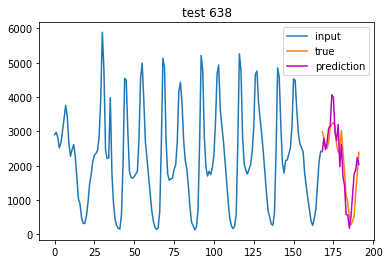

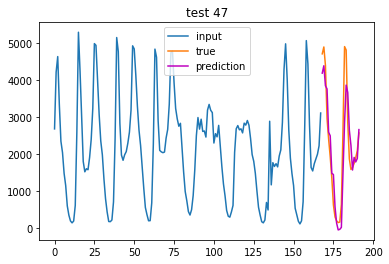

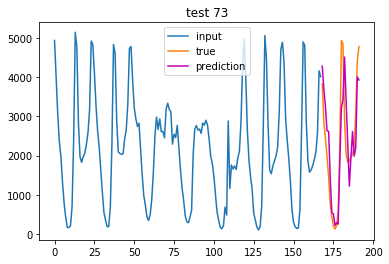

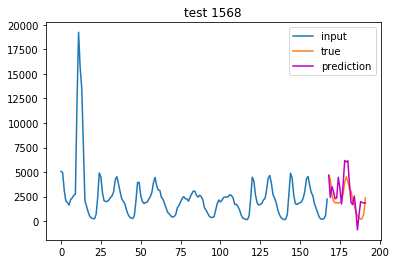

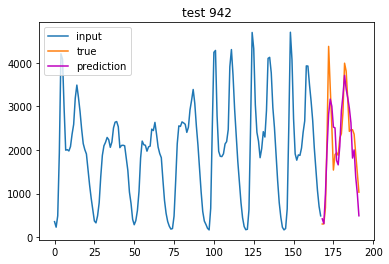

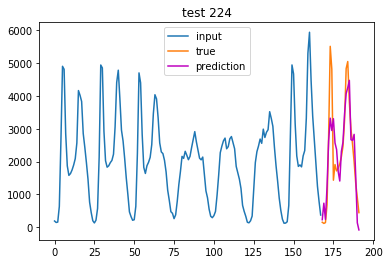

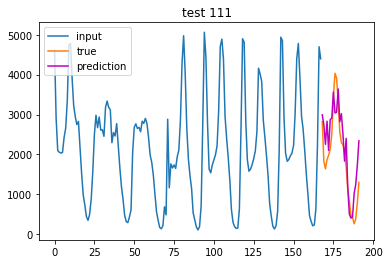

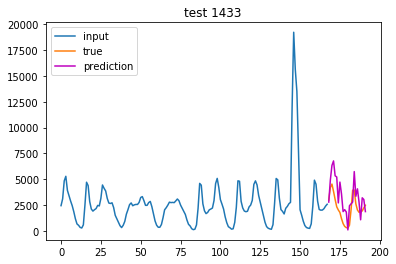

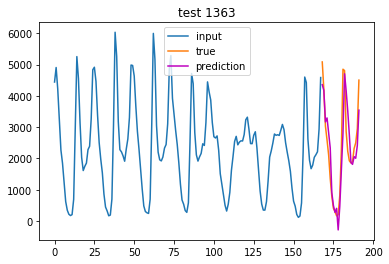

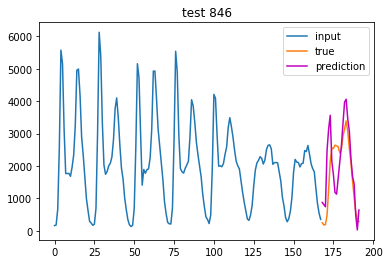

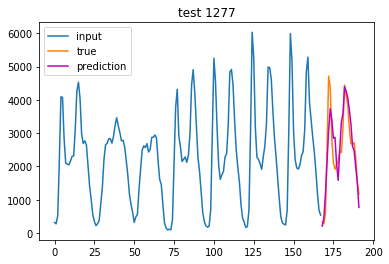

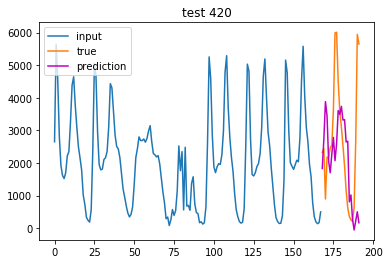

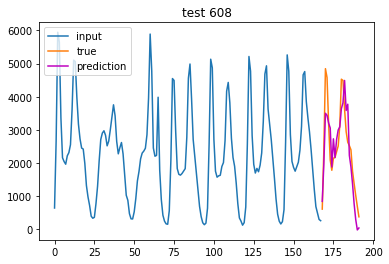

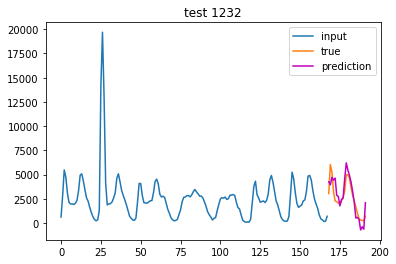

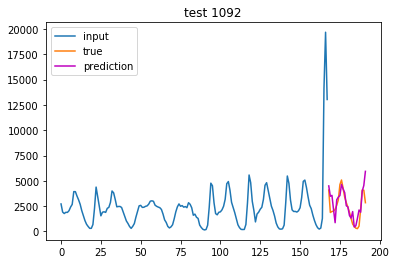

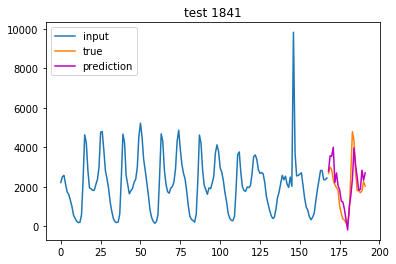

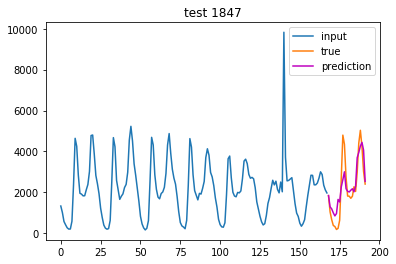

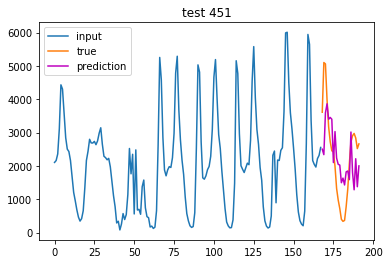

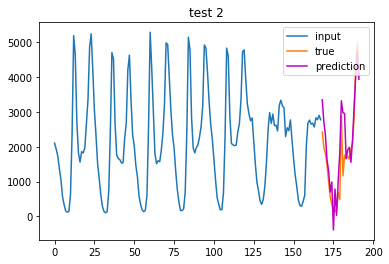

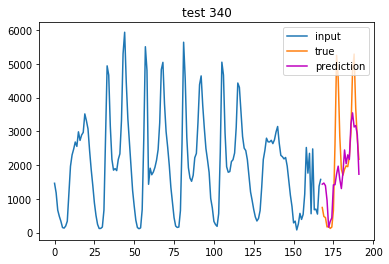

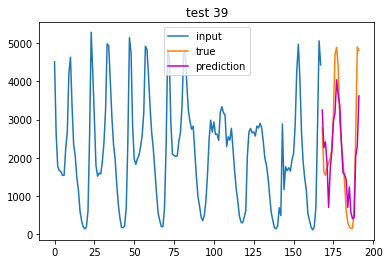

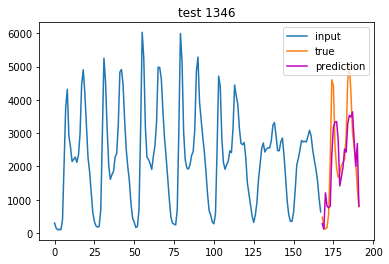

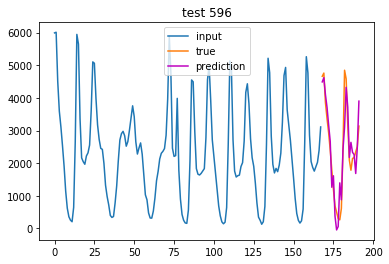

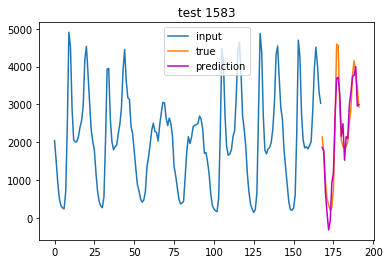

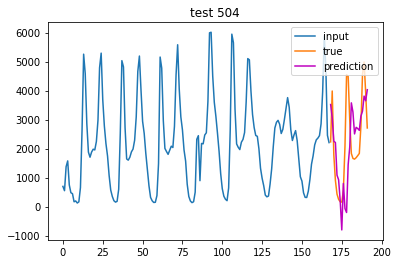

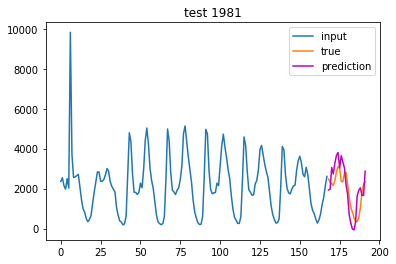

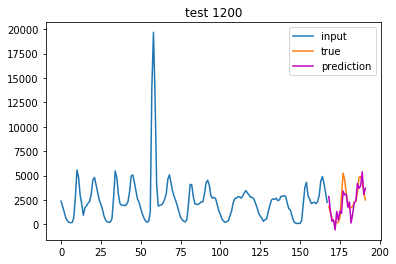

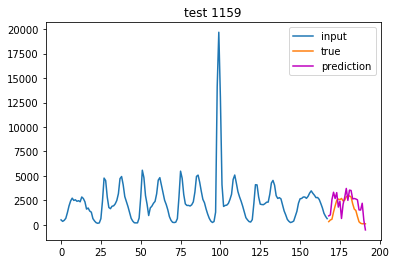

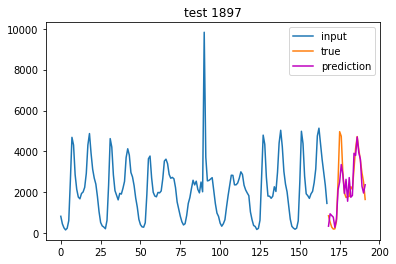

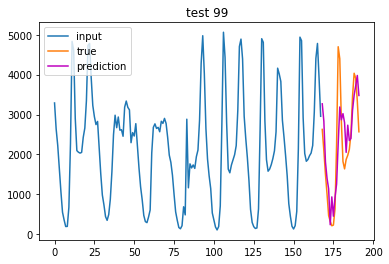

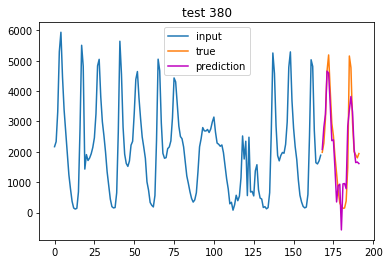

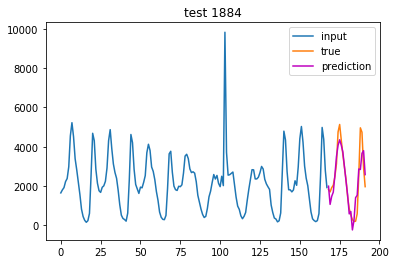

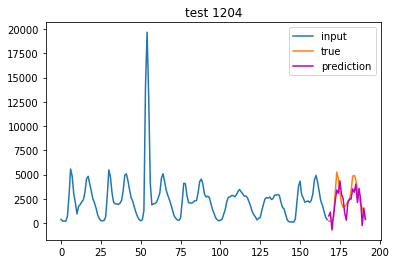

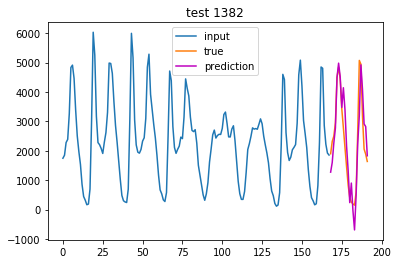

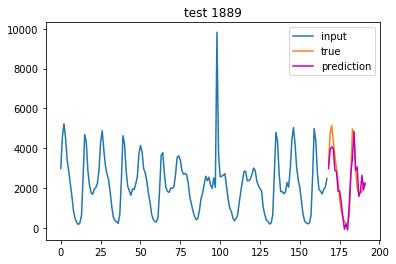

In [12]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

In [8]:
import pickle

benchmark = {'test_x': test_x, 
             'test_y_original': test_y_original,
             'scaler_benchmark': scaler_test}

with open('benchmark.pkl', 'wb') as handle:
    pickle.dump(benchmark , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
x = 1


In [4]:
x += 1 / 2

In [5]:
x

2.0